In [1]:
!pip install ucimlrepo
!pip install libsvm-official

  Preparing metadata (setup.py) ... done
  Created wheel for libsvm-official: filename=libsvm_official-3.32.0-cp310-cp310-linux_x86_64.whl size=123886 sha256=dbb2759ebcd7c39167651ff6df391728e763c5001873fe0c9feba7c40cb6f39f
  Stored in directory: /root/.cache/pip/wheels/61/3b/1b/73bb4869517f96a26c82b47ccdb9ec48f12f4466de2371eff6
Successfully built libsvm-official


/usr/local/lib/python3.10/dist-packages/libsvm/svm.py:147: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def csr_to_problem_jit(l, x_val, x_ind, x_rowptr, prob_val, prob_ind, prob_rowptr, indx_start):


Streaming output truncated to the last 5000 lines.
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 93.9587%
Cross Validation Accuracy = 94.9126%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 96.3434%
Cross Validation Accuracy = 69.4754%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 77.7424%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 89.9841%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 93.6407%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 65.5008%
Cross Validation Accuracy = 74.0859%
Cross Validation Accurac

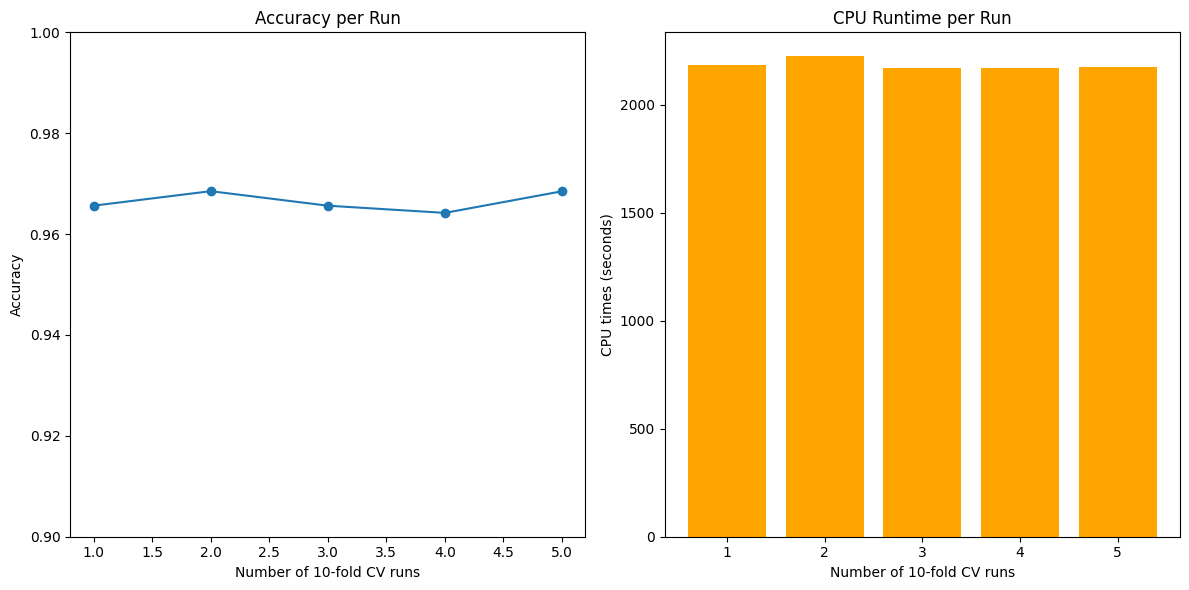

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from libsvm.svmutil import *
from ucimlrepo import fetch_ucirepo

np.random.seed(seed=42)

class FOASVM:
    def __init__(self, population_size=8, max_iterations=250, ax=20, bx=10, ay=20, by=10):
        self.population_size = population_size
        self.max_iterations = max_iterations
        self.ax = ax
        self.bx = bx
        self.ay = ay
        self.by = by

    def initialize_population(self):
        self.X_axis = np.random.uniform(-1, 1, 2)
        self.Y_axis = np.random.uniform(-1, 1, 2)

    def smell_concentration(self, C, gamma, X, y):
        prob = svm_problem(y.tolist(), X.tolist())
        param = svm_parameter(f'-s 0 -t 2 -c {C} -g {gamma} -v 5')
        score = svm_train(prob, param)
        return score / 100  # Convert percentage to fraction

    def search(self, X, y):
        best_score = -np.inf
        best_C = 0
        best_gamma = 0

        for _ in range(self.max_iterations):
            X_pos = self.X_axis + self.ax * np.random.rand(self.population_size, 2) - self.bx
            Y_pos = self.Y_axis + self.ay * np.random.rand(self.population_size, 2) - self.by

            D = np.sqrt(X_pos**2 + Y_pos**2)
            S = 1 / D

            for i in range(self.population_size):
                C = 2**np.clip(S[i, 0] * 20 - 5, -5, 15)
                gamma = 2**np.clip(S[i, 1] * 15 - 15, -15, 1)

                score = self.smell_concentration(C, gamma, X, y)

                if score > best_score:
                    best_score = score
                    best_C = C
                    best_gamma = gamma
                    self.X_axis = X_pos[i]
                    self.Y_axis = Y_pos[i]

        return best_C, best_gamma, best_score

    def fit(self, X, y):
        self.X = X
        self.y = y

        # Handle missing values by replacing them with the mean of the attribute
        df = pd.DataFrame(self.X)
        df.fillna(df.mean(), inplace=True)
        self.X = df.values

        scaler = MinMaxScaler(feature_range=(-1, 1))
        self.X = scaler.fit_transform(self.X)

        outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        all_outer_scores = []
        all_auc_scores = []
        all_sensitivity_scores = []
        all_specificity_scores = []
        all_run_times = []

        for _ in range(5):  # Repeat the 10-fold CV procedure 5 times
            outer_scores = []
            auc_scores = []
            sensitivity_scores = []
            specificity_scores = []
            start_time = time.time()

            for train_index, test_index in outer_cv.split(self.X, self.y):
                X_train, X_test = self.X[train_index], self.X[test_index]
                y_train, y_test = self.y[train_index], self.y[test_index]

                self.initialize_population()
                best_C, best_gamma, _ = self.search(X_train, y_train)

                prob = svm_problem(y_train.tolist(), X_train.tolist())
                param = svm_parameter(f'-s 0 -t 2 -c {best_C} -g {best_gamma} -b 1')
                model = svm_train(prob, param)

                p_label, p_acc, p_val = svm_predict(y_test.tolist(), X_test.tolist(), model, '-b 1')

                score = p_acc[0] / 100  # Accuracy
                outer_scores.append(score)

                # Calculate AUC from probability estimates
                positive_probabilities = [val[1] for val in p_val]  # Extract probability of positive class
                auc = roc_auc_score(y_test, positive_probabilities)
                auc_scores.append(auc)

                # Calculate sensitivity and specificity
                tn, fp, fn, tp = confusion_matrix(y_test, p_label).ravel()
                sensitivity = tp / (tp + fn)
                specificity = tn / (tn + fp)

                sensitivity_scores.append(sensitivity)
                specificity_scores.append(specificity)

            end_time = time.time()
            all_outer_scores.extend(outer_scores)
            all_auc_scores.extend(auc_scores)
            all_sensitivity_scores.extend(sensitivity_scores)
            all_specificity_scores.extend(specificity_scores)
            all_run_times.append(end_time - start_time)

        mean_accuracy = np.mean(all_outer_scores)
        std_accuracy = np.std(all_outer_scores)
        mean_auc = np.mean(all_auc_scores)
        std_auc = np.std(all_auc_scores)
        mean_sensitivity = np.mean(all_sensitivity_scores)
        std_sensitivity = np.std(all_sensitivity_scores)
        mean_specificity = np.mean(all_specificity_scores)
        std_specificity = np.std(all_specificity_scores)

        return (mean_accuracy, std_accuracy, mean_auc, std_auc,
                mean_sensitivity, std_sensitivity, mean_specificity, std_specificity,
                all_run_times, all_outer_scores)

# Fetch dataset
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

# Data
X = breast_cancer_wisconsin_original.data.features.values
y = breast_cancer_wisconsin_original.data.targets.values.ravel()

# Convert class labels from 2, 4 to 0, 1
y = np.where(y == 2, 0, 1)

# Initialize and fit FOASVM model
foa_svm = FOASVM()
(mean_accuracy, std_accuracy, mean_auc, std_auc,
 mean_sensitivity, std_sensitivity, mean_specificity, std_specificity,
 all_run_times, all_outer_scores) = foa_svm.fit(X, y)

print(f'Mean accuracy: {mean_accuracy:.4f}')
print(f'Standard deviation of accuracy: {std_accuracy:.4f}')
print(f'Mean AUC: {mean_auc:.4f}')
print(f'Standard deviation of AUC: {std_auc:.4f}')
print(f'Mean sensitivity: {mean_sensitivity:.4f}')
print(f'Standard deviation of sensitivity: {std_sensitivity:.4f}')
print(f'Mean specificity: {mean_specificity:.4f}')
print(f'Standard deviation of specificity: {std_specificity:.4f}')

# Plotting accuracy and CPU runtime per run
plt.figure(figsize=(12, 6))

# Plot accuracy per run
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), [np.mean(all_outer_scores[i*10:(i+1)*10]) for i in range(5)], marker='o')
plt.title('Accuracy per Run')
plt.xlabel('Number of 10-fold CV runs')
plt.ylabel('Accuracy')
plt.ylim(0.90, 1)

# Plot CPU runtime per run as a bar chart
plt.subplot(1, 2, 2)
plt.bar(range(1, 6), all_run_times, color='orange')
plt.title('CPU Runtime per Run')
plt.xlabel('Number of 10-fold CV runs')
plt.ylabel('CPU times (seconds)')

plt.tight_layout()
plt.show()
